# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier
### Henry Yau


---
## Step 0: Load The Data

In [95]:
# Load data
import pickle
import numpy as np
import tensorflow as tf

#Data has been pre-pickled

training_file = './data/train.p'
validation_file='./data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], np.int32(train['labels'])
X_valid, y_valid = valid['features'], np.int32(valid['labels'])
X_test, y_test = test['features'], np.int32(test['labels'])


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [96]:
#Print out data set summary

#number of training samples
n_train = len(y_train)
#Number of validation examples
n_validation = len(y_valid)
#Number of testing examples.
n_test = len(y_test)

image_shape = X_train[0].shape

#Numer of unique classes/labels there are in the dataset.
classes_labels = np.unique(y_train)
n_classes = len(classes_labels)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Dataset Visualization

Visualize the German Traffic Signs Dataset using the pickled file(s). 

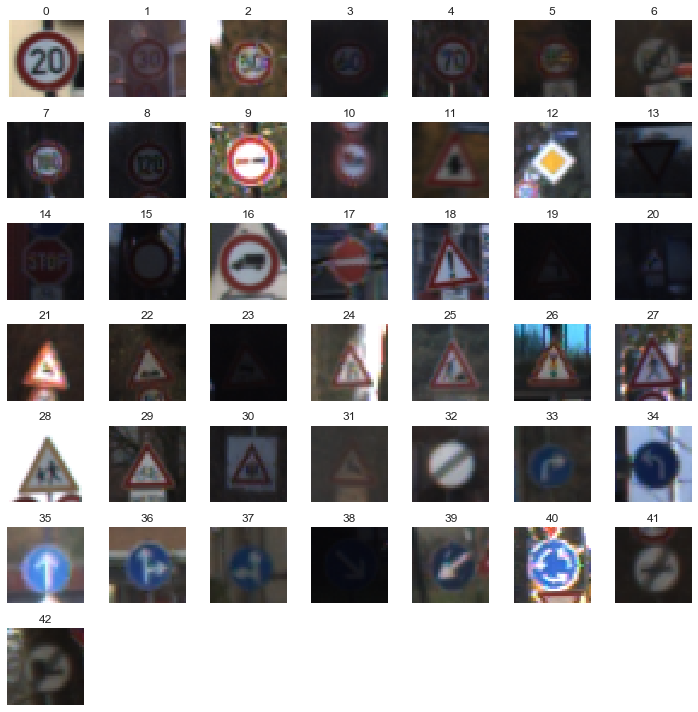

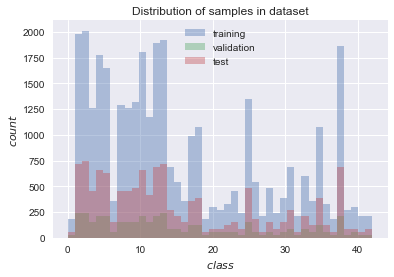

In [97]:
### Data exploration visualization code goes here.
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

plt.figure(figsize = (10,10))

#show example of each type of sign
#also keep a vector of class label counts
label_cnt = np.zeros(n_classes)
for i in range(0,n_classes):
    img_ind = np.where(y_train==i)   
    label_cnt[i] = len(img_ind[0])
    plt.subplot(7,7,i+1)
    plt.grid(False)
    
    plt.tick_params(
        axis='x',        
        which='both',    
        bottom='off',    
        top='off',       
        labelbottom='off')
    plt.tick_params(
        axis='y',        
        which='both',    
        left='off',    
        right='off',       
        labelleft='off')
    
    plt.title(y_train[img_ind[0][0]])
    plt.imshow(X_train[img_ind[0][0]])
plt.tight_layout()  
plt.show()


#plt.subplot(1,3,1)
sns.distplot(y_train, bins=n_classes, kde=False,label="training")
#plt.subplot(1,3,2)
sns.distplot(y_valid, bins=n_classes, kde=False,label="validation")
#plt.subplot(1,3,3)
sns.distplot(y_test, bins=n_classes, kde=False,label="test")
plt.legend();
plt.ylabel("$count$")
plt.xlabel("$class$")
plt.title('Distribution of samples in dataset')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).


### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [98]:
#Convert RGB image data to grayscale quickly as a vectorized operation
#also normalize the grayscale data 

def rgb_to_grey(X_in):
    X_out = ((X_in[:,:,:,0]*0.21+X_in[:,:,:,1]*0.72+X_in[:,:,:,2]*0.07)) #luminosity version of rgb to greyscale conversion
    X_out = (X_out-128.0)/128.0 #normalize -1 to 1
    X_out = X_out[..., np.newaxis] #make into 4D tensor
    
    return X_out
    

X_train_grey = rgb_to_grey(X_train)
X_valid_grey = rgb_to_grey(X_valid)
X_test_grey = rgb_to_grey(X_test)

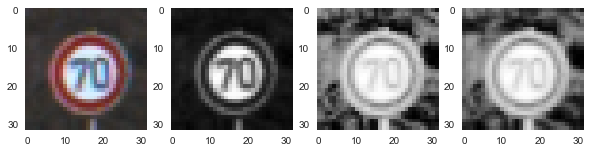

In [99]:
#Provide functions for image augmentation, randomaly rotate and equalize the training images
import cv2 # use openCV for arbitrary image rotation and histogram equalization
from tqdm import tnrange, tqdm_notebook
from sklearn.utils import shuffle

def rotate_random(image_in,max_rot):
    
    image_work = image_in.squeeze()

    #cv2.equalizeHist requires a 8bit greyscale.
    image_CV_8UC1 = np.array((image_work+1) * 127, dtype = np.uint8)

    rows,cols = image_work.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),max_rot*(np.random.rand()-0.5)/0.5,1)
    dst = cv2.warpAffine(image_CV_8UC1,M,(cols,rows))
    
    dst = (dst-128.0)/128.0

    return dst[..., np.newaxis]

def equalize_histogram(image_in):
    image_work = image_in.squeeze()
    
    #cv2.equalizeHist requires a 8bit greyscale.
    image_CV_8UC1 = np.array((image_work+1) * 127, dtype = np.uint8)    
    image_work = cv2.equalizeHist(image_CV_8UC1)
    image_work = (image_work-128.0)/128.0
    return image_work[..., np.newaxis]

#Sample outputs

rnd_ind = int(np.random.rand()*n_train)
plt.figure(figsize = (10,10))
plt.subplot(1,4,1)
plt.imshow(X_train[rnd_ind,:,:])
plt.grid(False)
plt.subplot(1,4,2)
plt.imshow(X_train_grey[rnd_ind,:,:,0], cmap='gray')
plt.grid(False)
plt.subplot(1,4,3)
rot_imag_hist = equalize_histogram(X_train_grey[rnd_ind])
plt.imshow(rot_imag_hist[:,:,0], cmap='gray')
plt.grid(False)
plt.subplot(1,4,4)

rot_imag = rotate_random(rot_imag_hist,10)
plt.imshow(rot_imag[:,:,0], cmap='gray')
                    
plt.grid(False)
plt.show()



In [44]:
# Augment the test set with rotations and enchancements

#first, shuffle the training dataset
X_train_grey, y_train = shuffle(X_train_grey, y_train)

#quickly initialize an array of same shape, should probably preallocate the correct array size
X_train_augment = X_train_grey[range(0,1)]
y_train_augment = y_train[range(0,1)]

for i in tnrange(n_train, desc='rotating/equalizing training images'):
    
    if label_cnt[y_train[i]]<1000: #want more examples for the under represented
        if i%1 ==0: #images already shuffled, select a subgroup to modify then append
            tmp_image = equalize_histogram(X_train_grey[i])
            tmp_image = rotate_random(tmp_image, 25)            

            X_train_augment = np.append(X_train_augment, [tmp_image], axis=0)
            y_train_augment = np.append(y_train_augment, y_train[i] )
            
print(X_train_augment.shape[0])  
#add to training set
X_train_augmented = np.append(X_train_grey,X_train_augment, axis=0)
y_train_augmented = np.append(y_train,y_train_augment, axis=0)
        


10110


### Model Architecture

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def Sign_LeNet(input_x, drop_keep_rate):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1

    init_norm = lambda shape, dtype,partition_info:tf.random_normal(shape,mu,sigma)#use a lambda function to create an initializer
    init_zero = lambda shape, dtype,partition_info:tf.zeros(shape)#use a lambda function to create an initializer
    
    weights_array = {
        'weight1':tf.get_variable("weight1", shape = [5,5,1,24], initializer=init_norm), #5x5 patch 1 channel in 6 filters
        'weight2':tf.get_variable("weight2", shape = [5,5,24,48],initializer=init_norm), #5x5 patch 6 channels in 16 filters
        'weight3':tf.get_variable("weight3", shape = [1200,256],initializer=init_norm), #fully connected layer
        'weight4':tf.get_variable("weight4", shape = [256,96],initializer=init_norm),
        'weight5':tf.get_variable("weight5", shape = [96,n_classes],initializer=init_norm)}
    bias_array = {
        'bias1':tf.get_variable("bias1", shape = [24], initializer=init_norm),
        'bias2':tf.get_variable("bias2", shape = [48], initializer=init_norm),
        'bias3':tf.get_variable("bias3", shape = [256], initializer=init_norm),
        'bias4':tf.get_variable("bias4", shape = [96], initializer=init_norm),
        'bias5':tf.get_variable("bias5", shape = [n_classes], initializer=init_norm)
    } 
    
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x24
    layer_1 = tf.nn.conv2d(input_x, weights_array['weight1'], strides = [1,1,1,1], padding='VALID')
    layer_1 = tf.nn.bias_add(layer_1, bias_array['bias1'])
    #Activation.
    layer_1 = tf.nn.relu(layer_1)

    #Pooling. Input = 28x28x24 Output = 14x14x24
    layer_1_pool = tf.nn.max_pool(layer_1, ksize = [1,2,2,1], strides=[1,2,2,1], padding='SAME')

    #Layer 2: Convolutional. Output = 10x10x48.
    layer_2 = tf.nn.conv2d(layer_1_pool, weights_array['weight2'], strides = [1,1,1,1], padding='VALID')
    layer_2 = tf.nn.bias_add(layer_2, bias_array['bias2'])
    #Activation.
    layer_2 = tf.nn.relu(layer_2)
    #Pooling. Input = 10x10x16. Output = 5x5x48.
    layer_2_pool = tf.nn.max_pool(layer_2, ksize = [1,2,2,1], strides=[1,2,2,1], padding='SAME')

    #Flatten. Input = 5x5x48. Output = 1200.
    layer_2_flat = tf.reshape(layer_2_pool, [-1, 1200])
    
    #Layer 3: Fully Connected. Input = 1200. Output = 256.    
    layer_3 = tf.matmul(layer_2_flat,  weights_array['weight3'])+ bias_array['bias3'] 
    
    #Activation.
    layer_3 = tf.nn.relu(layer_3)
    #dropout
    layer_3 = tf.nn.dropout(layer_3, drop_keep_rate)

    #Layer 4: Fully Connected. Input = 256. Output = 96.
    layer_4 = tf.matmul(layer_3,  weights_array['weight4'])+ bias_array['bias4'] 
    #Activation.
    layer_4 = tf.nn.relu(layer_4)
    #dropout
    layer_4 = tf.nn.dropout(layer_4, drop_keep_rate)

    #Layer 5: Fully Connected. Input = 96. Output = n_classes.    
    y_out = tf.matmul(layer_4,  weights_array['weight5'])+ bias_array['bias5'] 
    
    layer_names = {"layer_1":layer_1,
                  "layer_2":layer_2,
                  "layer_3":layer_3,
                  "layer_1_pool":layer_1_pool,
                  "layer_2_pool":layer_2_pool}

    return y_out, layer_names

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
EPOCHS = 25
#BATCH_SIZE = 48
BATCH_SIZE = 48
tf.reset_default_graph()

#x = tf.placeholder(tf.float32, (None, 32, 32, 3)) #color version
x = tf.placeholder(tf.float32, (None, 32, 32, 1)) #gray version
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32,(None))


one_hot_y = tf.one_hot(y,n_classes) #keep labels in a one hot tensor

rate = 0.001
y_out, layer_names = Sign_LeNet(x,keep_prob)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=y_out)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)


total_loss = tf.losses.hinge_loss(one_hot_y, logits= y_out)
mean_loss = tf.reduce_mean(total_loss)

training_operation = optimizer.minimize(mean_loss)
#training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(y_out, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1}) #when evaluating, don't do drops
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training...
EPOCH 1 ...
Validation Accuracy = 0.7184
Training Accuracy = 0.7609
EPOCH 2 ...
Validation Accuracy = 0.8995
Training Accuracy = 0.9474
EPOCH 3 ...
Validation Accuracy = 0.9440
Training Accuracy = 0.9854
EPOCH 4 ...
Validation Accuracy = 0.9567
Training Accuracy = 0.9922
EPOCH 5 ...
Validation Accuracy = 0.9628
Training Accuracy = 0.9946
EPOCH 6 ...
Validation Accuracy = 0.9712
Training Accuracy = 0.9972
EPOCH 7 ...
Validation Accuracy = 0.9624
Training Accuracy = 0.9972
EPOCH 8 ...
Validation Accuracy = 0.9653
Training Accuracy = 0.9972
EPOCH 9 ...
Validation Accuracy = 0.9673
Training Accuracy = 0.9987
EPOCH 10 ...
Validation Accuracy = 0.9692
Training Accuracy = 0.9989
EPOCH 11 ...
Validation Accuracy = 0.9692
Training Accuracy = 0.9990
EPOCH 12 ...
Validation Accuracy = 0.9628
Training Accuracy = 0.9990
EPOCH 13 ...
Validation Accuracy = 0.9735
Training Accuracy = 0.9992
EPOCH 14 ...
Validation Accuracy = 0.9676
Training Accuracy = 0.9988
EPOCH 15 ...
Validation Accurac

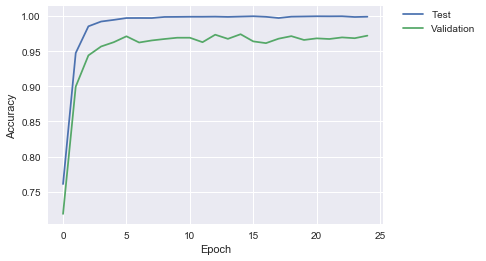

Model saved


In [9]:
from tqdm import tnrange, tqdm_notebook
from sklearn.utils import shuffle

accuracy_valid_vec = np.zeros(EPOCHS)
accuracy_train_vec = np.zeros(EPOCHS)

with tf.Session() as sess:
    with tf.device("/gpu:0"): #or /cpu:0
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train_grey)

        print("Training...")
        
        for i in range(EPOCHS):                     
            X_train_grey, y_train = shuffle(X_train_grey, y_train)
            
            #a progress bar to see things are moving along
            #for offset in tnrange(0, num_examples, BATCH_SIZE, desc="Training Epoch", leave = False):
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE

                #batch_x, batch_y = X_train_grey[offset:end], y_train[offset:end]
                
                #use augmented 
                batch_x, batch_y = X_train_augmented[offset:end], y_train_augmented[offset:end]
                
                
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.7})
               
            training_accuracy = evaluate(X_train_grey, y_train)
            validation_accuracy = evaluate(X_valid_grey, y_valid)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.4f}".format(validation_accuracy))
            print("Training Accuracy = {:.4f}".format(training_accuracy))
            #print()
            accuracy_train_vec[i] = training_accuracy
            accuracy_valid_vec[i] = validation_accuracy
        
        plt.plot(range(0,EPOCHS),accuracy_train_vec,label="Test")
        plt.plot(range(0,EPOCHS),accuracy_valid_vec,label="Validation")
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.show()

        saver.save(sess, './sign_lenet')
        print("Model saved")

In [10]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_grey, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\sign_lenet
Test Accuracy = 0.957


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

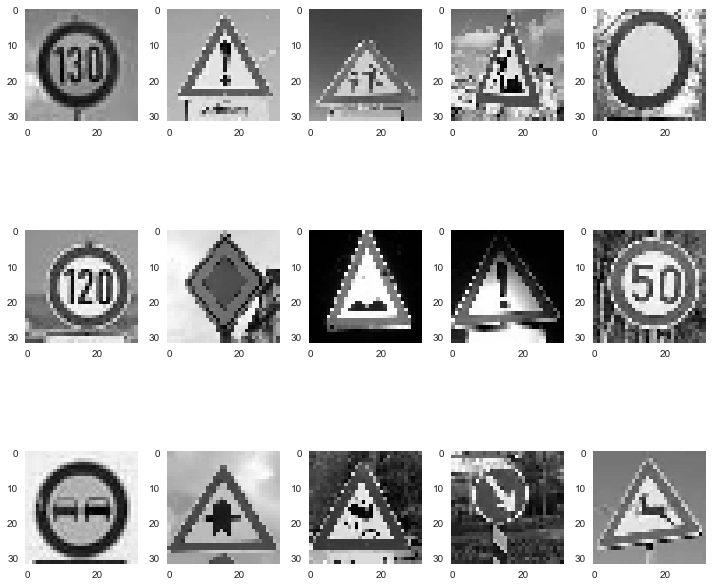

In [85]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import cv2
import pandas as pd
import glob



df_labels = pd.read_csv('./signnames.csv')
sign_labels_dict = df_labels['SignName']
#print(df_labels['SignName'])

#load all the jpg images in the data folder. convert to grayscale, resize and normalize
images_list = [cv2.imread(file,cv2.IMREAD_GRAYSCALE) for file in glob.glob("./data/*.jpg")]
n_images = len(images_list)
images_resized = np.empty([n_images,32,32,1])

plt.figure(figsize = (10,10))
for i in range(0,n_images):
    width, height = images_list[i].shape[:2]
    img_temp = cv2.resize(images_list[i],None,fx=32/height, fy=32/width, interpolation = cv2.INTER_CUBIC)
    
    fig1 = plt.figure(1)
    
    fig1.add_subplot(3,5,i+1) 
    plt.grid(False)
    plt.imshow(img_temp, cmap='gray')
    
    img_temp = (img_temp-128.0)/128.0
    
    img_temp = equalize_histogram(img_temp)
    images_resized[i] =img_temp#[...,np.newaxis]
plt.tight_layout()
plt.show()

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from .\sign_lenet


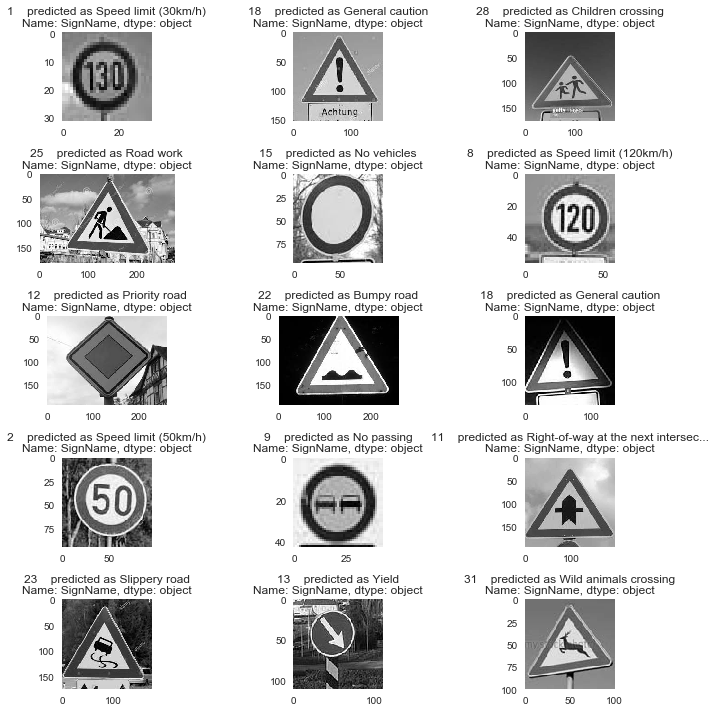

In [86]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
y_predict = tf.nn.softmax(y_out)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    y_scores = sess.run(y_predict, feed_dict={x:images_resized, keep_prob:1})


scores_op, indices_op = tf.nn.top_k(y_scores,1)
with tf.Session() as sess:
    scores = scores_op.eval()
    indices = indices_op.eval()

#fig, ax = plt.subplots()


#for i in range(0,n_images):

 #   print(indices[i])
    
    
    
  #  plt.imshow(images_list[i], cmap='gray')
  #  plt.grid(False)
  #  plt.figure(figsize = (2,2))
    
  #  plt.show()

plt.figure(figsize = (10,10))
for i in range(0,n_images): 
    
    plt.subplot(5,3,i+1)
    
    #plt.figure(figsize = (3,3))
    plt.grid(False)
    plt.imshow(images_list[i], cmap='gray')
    
    plt.title('predicted as ' +sign_labels_dict[indices[i]])
plt.tight_layout()  
plt.show()


### Analyze Performance

In [88]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
y_test_true = [99,18,28,25,15,8,12,22,18,2,9,11,23,13,31]
diff_count = 0

#neglect item 0 because it isn't classifiable
for i in range(1,len(indices)):
    if indices[i][0]!=y_test_true[i]:
        diff_count+=1
print(((len(indices)-diff_count)/len(indices))*100,'% correct')
print('This neglects the first image as it is unclassifiable and only included to analyze the softmax probabilities')


100.0 % correct
This neglects the first image as it is unclassifiable and only included to analyze the softmax probabilities


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). 


[[  9.99992490e-01   6.58628642e-06   9.99403142e-07   3.03684935e-08
    3.00972971e-08]
 [  1.00000000e+00   1.36505589e-30   3.78738543e-31   1.37592413e-31
    2.39523343e-32]
 [  9.98191535e-01   1.80228602e-03   4.19534626e-06   1.16714978e-06
    1.72722608e-07]
 [  9.93381619e-01   5.95746189e-03   3.26264417e-04   1.01191596e-04
    6.95852505e-05]
 [  9.94898975e-01   4.76250006e-03   1.53577857e-04   1.06956853e-04
    2.31494487e-05]
 [  1.00000000e+00   3.08949841e-17   1.83080480e-22   1.42129233e-22
    1.19768851e-22]
 [  1.00000000e+00   8.22221143e-13   1.10079867e-13   5.72371469e-14
    1.86519196e-14]
 [  9.87354100e-01   1.24097187e-02   1.36871124e-04   4.80079470e-05
    1.41683768e-05]
 [  1.00000000e+00   1.06342064e-08   2.12897611e-09   1.23326427e-09
    1.06702847e-09]
 [  9.71760869e-01   2.71552075e-02   9.17389814e-04   1.18871780e-04
    1.42574245e-05]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.0000

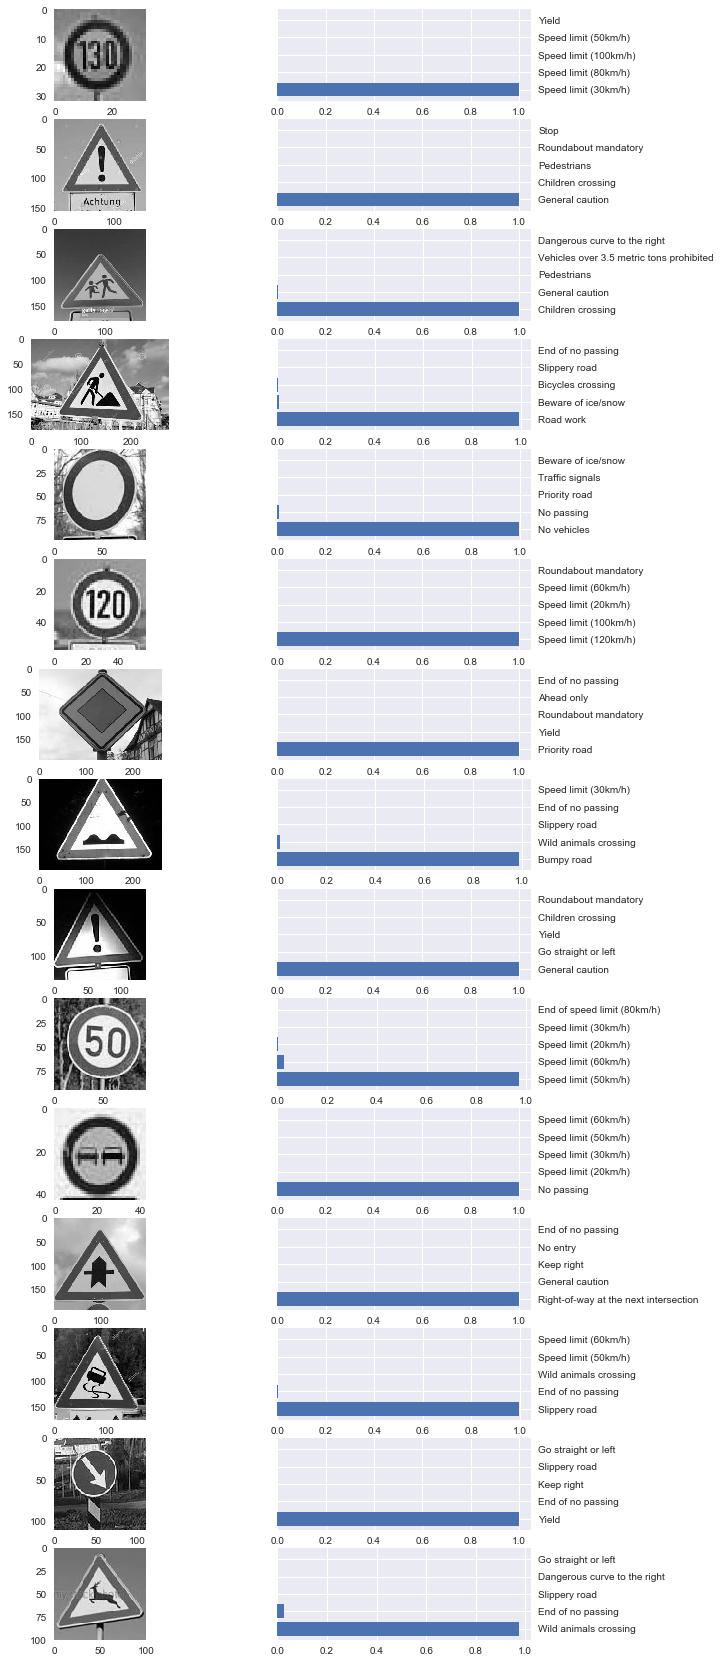

In [89]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
scores_op, indices_op = tf.nn.top_k(y_scores,5)
with tf.Session() as sess:
    scores = scores_op.eval()
    indices = indices_op.eval()





print(scores)
print(indices)
plt.figure(figsize = (10,30))
for i in range(0,n_images):
    
    ax = plt.subplot(15,2,2+i*2)
    plt.barh(range(0,5), scores[i])
    plt.yticks(range(0,5), sign_labels_dict[indices[i]])
    
    ax.yaxis.tick_right()
    
    plt.subplot(15,2,1+i*2)
    plt.grid(False)
    plt.imshow(images_list[i], cmap='gray')
    
    
    
plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.



INFO:tensorflow:Restoring parameters from .\sign_lenet


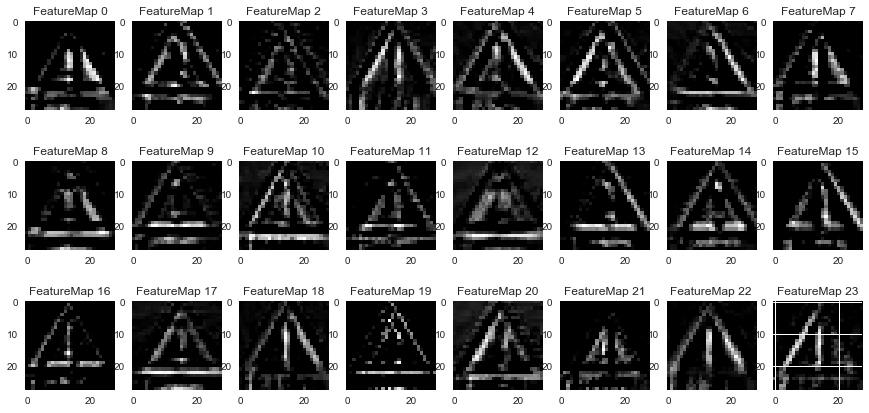

In [94]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.


# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    
    for featuremap in range(featuremaps):
        plt.grid(False)
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        #print(activation[0,:,:, featuremap].shape)


sess = tf.InteractiveSession()
saver.restore(sess, tf.train.latest_checkpoint('.'))

outputFeatureMap(images_resized[1][np.newaxis,...], layer_names["layer_1"])
plt.show()
#outputFeatureMap(images_resized[0][np.newaxis,...], layer_names["layer_1_pool"])
#plt.show()
#outputFeatureMap(images_resized[0][np.newaxis,...], layer_names["layer_2"])
#plt.show()
#outputFeatureMap(images_resized[0][np.newaxis,...], layer_names["layer_2_pool"])
#plt.show()
#outputFeatureMap(images_resized[0][np.newaxis,...], layer_names["layer_3"])

